In [1]:
# fix for keras v3.0 update
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1' 

# tensorflow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# python based
import random
from pathlib import Path
import time
import argparse
import json
import submitit
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# custom code
from OptimizedDataGenerator import OptimizedDataGenerator
from loss import *
from models import *

2024-09-11 14:55:29.883424: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-11 14:55:29.886133: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-11 14:55:29.917457: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-11 14:55:29.917480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-11 14:55:29.918397: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# set gpu growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

output_directory = Path("./training_output2").resolve()
batch_size = 500
val_batch_size = 500

if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
os.makedirs(output_directory, exist_ok=True)
print(output_directory)

# paths
data_directory_path = "/home/elizahoward/cmspix28-mc-sim/minbiasDataSet1/"
    
# create tf records directory
stamp = '%08x' % random.randrange(16**8)
tfrecords_dir_train = Path(output_directory, f"tfrecords_train_{stamp}").resolve()
tfrecords_dir_validation = Path(output_directory, f"tfrecords_validation_{stamp}").resolve()
if not os.path.exists(tfrecords_dir_train):
    os.mkdir(tfrecords_dir_train)
    os.mkdir(tfrecords_dir_validation)

# training generator
start_time = time.time()
training_generator = OptimizedDataGenerator(
    data_directory_path = data_directory_path,
    labels_directory_path = data_directory_path,
    is_directory_recursive = False,
    file_type = "parquet",
    data_format = "3D",
    batch_size = batch_size,
    to_standardize= False,
    include_y_local= True,
    labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
    input_shape = (2,13,21), # (20,13,21),
    transpose = (0,2,3,1),
    save=True,
    use_time_stamps = [0,19],
    tfrecords_dir = tfrecords_dir_train,
)
print("--- Training generator %s seconds ---" % (time.time() - start_time))

data_directory_path = "/home/elizahoward/cmspix28-mc-sim/minbiasDataSet2/"

start_time = time.time()
validation_generator = OptimizedDataGenerator(
    data_directory_path = data_directory_path,
    labels_directory_path = data_directory_path,
    is_directory_recursive = False,
    file_type = "parquet",
    data_format = "3D",
    batch_size = val_batch_size,
    to_standardize= False,
    include_y_local= True,
    labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
    input_shape = (2,13,21), # (20,13,21),
    transpose = (0,2,3,1),
    use_time_stamps = [0,19],
    tfrecords_dir = tfrecords_dir_validation,
)
print("--- Validation generator %s seconds ---" % (time.time() - start_time))

/home/elizahoward/smart-pixels-ml/training_output2
Directory /home/elizahoward/smart-pixels-ml/training_output2/tfrecords_train_b3854f25 is removed...


2024-09-11 14:55:32.443722: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Processing Files...:   0%|          | 0/20 [00:00<?, ?it/s]

Saving batches as TFRecords: 100%|██████████| 50/50 [00:02<00:00, 17.52it/s]


--- Training generator 8.028961420059204 seconds ---
Directory /home/elizahoward/smart-pixels-ml/training_output2/tfrecords_validation_b3854f25 is removed...


Saving batches as TFRecords: 100%|██████████| 11/11 [00:01<00:00, 10.66it/s]


--- Validation generator 5.938417196273804 seconds ---


In [3]:
 # compiles model
n_filters = 5 # model number of filters
pool_size = 3 # model pool size
start_time = time.time()
model=CreateModel(shape=(13,21,3), n_filters=n_filters, pool_size=pool_size)
model.summary()
print("--- Model create and compile %s seconds ---" % (time.time() - start_time))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 21, 3)]       0         
                                                                 
 q_separable_conv2d (QSepar  (None, 11, 19, 5)         47        
 ableConv2D)                                                     
                                                                 
 q_activation (QActivation)  (None, 11, 19, 5)         0         
                                                                 
 q_conv2d (QConv2D)          (None, 11, 19, 5)         30        
                                                                 
 q_activation_1 (QActivatio  (None, 11, 19, 5)         0         
 n)                                                              
                                                                 
 average_pooling2d (Average  (None, 3, 6, 5)           0     

In [38]:
learning_rate = 0.0000001
model.compile(optimizer=Adam(learning_rate=learning_rate), loss=custom_loss)

In [39]:
epochs = 10
early_stopping_patience = 50

# launch quick training once gpu is available
es = EarlyStopping(
        patience=early_stopping_patience,
        restore_best_weights=True
)
    
# checkpoint path
checkpoint_filepath = Path(output_directory, 'weights.{epoch:02d}-t{loss:.2f}-v{val_loss:.2f}.hdf5').resolve()
mcp = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        save_best_only=True,
)

# train
history = model.fit(x=training_generator,
                        validation_data=validation_generator,
                        callbacks=[mcp],
                        epochs=epochs,
                        shuffle=False, # shuffling now occurs within the data-loader
                        verbose=1)
    
# clean up tf records
#shutil.rmtree(tfrecords_dir_train)
#shutil.rmtree(tfrecords_dir_validation)

Epoch 1/10


50/50 [==============================] - 6s 66ms/step - loss: -1768.1815 - val_loss: -1314.7186
Epoch 2/10
50/50 [==============================] - 3s 50ms/step - loss: -1778.7593 - val_loss: -1307.6670
Epoch 3/10
50/50 [==============================] - 3s 52ms/step - loss: -1772.8452 - val_loss: -1313.6558
Epoch 4/10
50/50 [==============================] - 3s 50ms/step - loss: -1763.7761 - val_loss: -1305.2345
Epoch 5/10
50/50 [==============================] - 3s 50ms/step - loss: -1753.0526 - val_loss: -1302.4359
Epoch 6/10
50/50 [==============================] - 3s 50ms/step - loss: -1767.2985 - val_loss: -1306.6541
Epoch 7/10
50/50 [==============================] - 3s 50ms/step - loss: -1756.0925 - val_loss: -1319.9827
Epoch 8/10
50/50 [==============================] - 3s 50ms/step - loss: -1765.4772 - val_loss: -1311.6472
Epoch 9/10
50/50 [==============================] - 3s 51ms/step - loss: -1756.7605 - val_loss: -1304.7699
Epoch 10/10
50/50 [=============================

In [40]:
model.load_weights("/home/elizahoward/smart-pixels-ml/training_output2/weights.01-t-1778.85-v-1310.17.hdf5")

In [32]:
p_test = model.predict(validation_generator)

11/11 [==============================] - 1s 57ms/step


In [33]:
complete_truth = None
for _, y in tqdm(validation_generator):
        if complete_truth is None:
            complete_truth = y
        else:
            complete_truth = np.concatenate((complete_truth, y), axis=0)

100%|██████████| 11/11 [00:00<00:00, 28.05it/s]


In [34]:
maxval=1e9
minval=1e-9

# creates df with all predicted values and matrix elements - 4 predictions, all 10 unique matrix elements
df = pd.DataFrame(p_test,columns=['x','M11','y','M22','cotA','M33','cotB','M44','M21','M31','M32','M41','M42','M43'])
df['x'] *= 75
df['y'] *= 18.75
df['cotA'] *= 8
df['cotB'] *= 0.5

# stores all true values in same matrix as xtrue, ytrue, etc.
df['xtrue'] = complete_truth[:,0]*75
df['ytrue'] = complete_truth[:,1]*18.75
df['cotAtrue'] = complete_truth[:,2]*8
df['cotBtrue'] = complete_truth[:,3]*0.5
df['M11'] = minval+tf.math.maximum(df['M11'], 0)
df['M22'] = minval+tf.math.maximum(df['M22'], 0)
df['M33'] = minval+tf.math.maximum(df['M33'], 0)
df['M44'] = minval+tf.math.maximum(df['M44'], 0)

df['sigmax'] = abs(df['M11'])
df['sigmay'] = np.sqrt(df['M21']**2 + df['M22']**2)
df['sigmacotA'] = np.sqrt(df['M31']**2+df['M32']**2+df['M33']**2)
df['sigmacotB'] = np.sqrt(df['M41']**2+df['M42']**2+df['M43']**2+df['M44']**2)

# calculates residuals for x, y, cotA, cotB
residualsx = np.abs(df['xtrue'] - df['x'])
residualsy = np.abs(df['ytrue'] - df['y'])
residualsA = np.abs(df['cotAtrue'] - df['cotA'])
residualsB = np.abs(df['cotBtrue'] - df['cotB'])

# stores results as csv
#df.to_csv("test_4x4.csv",header=True,index=False)

In [35]:
# x
xmean, xstd = (np.mean(residualsx),np.std(residualsx))
print(f"mean and std residuals for x-midplane: ({xmean},{xstd})")
# y
ymean, ystd = (np.mean(residualsy),np.std(residualsy))
print(f"mean and std residuals for y-midplane: ({ymean},{ystd})")
# cotA
cotAmean, cotAstd = (np.mean(residualsA),np.std(residualsA))
print(f"mean and std residuals for cot(alpha): ({cotAmean},{cotAstd})")
# cotB
cotBmean, cotBstd = (np.mean(residualsB),np.std(residualsB))
print(f"mean and std residuals for cot(beta): ({cotBmean},{cotBstd})")


mean and std residuals for x-midplane: (9.740413665771484,11.786283493041992)
mean and std residuals for y-midplane: (1.6810656785964966,1.788089394569397)
mean and std residuals for cot(alpha): (0.4487745761871338,0.6009690165519714)
mean and std residuals for cot(beta): (0.033546578139066696,0.025599757209420204)


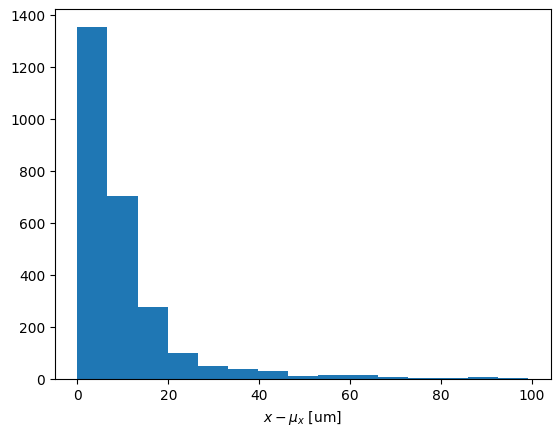

In [36]:
plt.hist(residualsx, bins = 15)
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')

#save_fig_path = os.path.join(base_dir, 'x_res_dist.png')
#plt.savefig(save_fig_path)

plt.show()

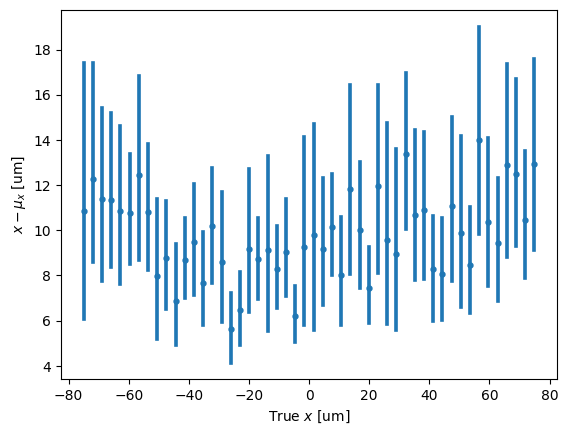

In [37]:
x = sns.regplot(x=df['xtrue'], y=residualsx, x_bins=np.linspace(-75,75,50), fit_reg=None, marker='.')
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$x-\mu_x$ [um]')

#save_fig_path = os.path.join(base_dir, 'x_vs_res.png')
#plt.savefig(save_fig_path)

plt.show()